# Analyzing Passive Acoustic Data with MHKiT

The following example illustrates how to read and analyze some basic parameters for passive acoustics data. Functionality to analyze .wav files recorded using hydrophones has been integrated into MHKiT to support analysis based on the IEC-TS 62600-40 standard.

The standard workflow for passive acoustics analysis is as follows:

1. Import .wav file
2. Calibrate data
3. Calculate spectral density
4. Calculate other parameters

We'll import a couple plotting tools and the acoustics module:

In [1]:
from cmocean.cm import thermal
import matplotlib.dates as mdates

from mhkit import acoustics

### Read in Hydrophone Measurements

Reading hydrophone .wav files in MHKiT use a base function called `read_hydrophone` from the acoustics.io submodule. This function reads in the raw ADC output in the file and converts it to a voltage with 64-bit float resolution. The peak voltage of the ADC is required and should be provided. If a sensitivity value is provided, the function will convert voltage to pressure; otherwise this data can be provided later using a calibration curve. The gain input is provided should the hydrophone utilize an amplifier gain, which is then added to the sensitivity.

In [2]:
P = acoustics.io.read_hydrophone(
    "data/acoustics/RBW_6661_20240601_053114.wav", 
    peak_V=3, 
    sensitivity=-177, 
    gain=0, 
    start_time="2024-06-01T05:31:14"
)

For icListen datafiles, only the filename is necessary to provide to read the file, as Ocean Sonics stores metadata in the .wav file header. To use a calibration curve with these measurements, set `sensitivity` to None and `use_metadata` to False.

In [3]:
P = acoustics.io.read_iclisten("data/acoustics/RBW_6661_20240601_053114.wav")
V = acoustics.io.read_iclisten(
    "data/acoustics/RBW_6661_20240601_053114.wav", 
    sensitivity=None, 
    use_metadata=False
)

Two wrapper functions are available for OceanInstruments Sountrap hydrophones and OceanSonics icListen hydrophone .wav files. These two manufacturers incorporate some required metadata into the files that is needed to parse the files properly, namely the peak voltage sent to the ADC and the beginning timestamp of the file.

For Soundtrap datafiles, the filename and sensitivity should be provided to return the measurements in units of pressure. If the hydrophone has been calibrated, set the sensitivity to None to return the measurements in voltage.

In [4]:
P = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", sensitivity=-177)
V = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", sensitivity=None)

### Mean Square Spectral Density

After the .wav file is read in, either in units of pressure or voltage, we calculate the mean-square spectral density of the timeseries using `sound_pressure_spectral_density`. This splits the timeseries into windows and uses fast Fourier transforms to convert the timeseries into the frequency domain, with units of Pa^2/Hz or V^2/Hz, depending on the input. The function takes the original datafile, the hydrophone's sampling rate, which is stored as an attribute of the measurement timeseries, and a window size in seconds as input.

In [5]:
# Create mean square spectral densities using 1 s windows.
spsd = acoustics.sound_pressure_spectral_density(V, V.fs, window=1)

### Applying Calibration Curves

For conducting scientific-grade analysis, it is critical to use calibration curves to correct spectral densities calculated from the hydrophone's raw pressure measurements. Hydrophones should be calibrated (i.e., a sensitivity calibration curve should be generated for a hydrophone) at least every few years.

A calibration curve consists of the hydrophone's sensitivity (in units of dB rel 1 V^2/uPa^2) vs frequency and should be applied to the spectral density we just calculated.

The easiest way to do this for MHKiT is to first copy the calibration curve into a CSV file, where the left column are the frequencies and the right column contains the sensitivity values. I use the function in the following codeblock to read in a CSV file I created with the column headers "Frequency" and "Analog Sensitivity".

In [6]:
import pandas as pd

def read_calibration_file(filename):
    calibration = pd.read_csv(filename, sep=",")
    calibration.index = calibration["Frequency"]
    calibration = calibration.to_xarray()
    return calibration["Analog Sensitivity"]

sensitivity_curve = read_calibration_file("data/acoustics/6247_calibration.csv")

Once we have the calibration (sensitivity) curve in an xarray DataArray, we can apply that to the mean square spectral density using the `apply_calibration` function. Calibration curves typically may or may not cover the entire range of the hydrophone, and these can be ignored or trimmed out later if desired. This function will linearly interpolate the curve onto the frequency vector of the spectral density, and a fill_value can be provided to extrapolate out and fill missing data.

In [7]:
# Use last value in calibration curve for higher frequencies
fill_Sf = sensitivity_curve[-1].values
spsd = acoustics.apply_calibration(spsd, sensitivity_curve, fill_value=fill_Sf)

### Mean Square Spectral Density Level

Now that we've applied the calibration curve, we can calculate mean square sound pressure levels from the mean square sound pressure spectral density. This means we're converted absolute pressure into relative pressure in log-space, the traditional means with which we measure sound. The function `sound_pressure_spectral_density_level` takes in our calibrated mean square values and calculates spectral density levels in decibels relative to 1 uPa (dB rel 1 uPa), the standard for underwater sound.
    
Sidenote: Sound in air is measured in decibels relative to 20 uPa, the minimum pressure level humans can hear. To convert between dB rel 1 uPa and dB rel 20 uPa, one simply needs to subtract 26 dB to the dB rel 1 uPa value.

In [8]:
spsdl = acoustics.sound_pressure_spectral_density_level(spsd)

Now that we have the mean squre spectral density levels, we can plot these data in spectograms, or waterfall plots, using the `plot_spectogram` function in the graphics submodule. To do this, we'll give the function the minimum and maximum frequencies to plot, as well as keyword arguments supplied to the matplotlib pcolormesh function.

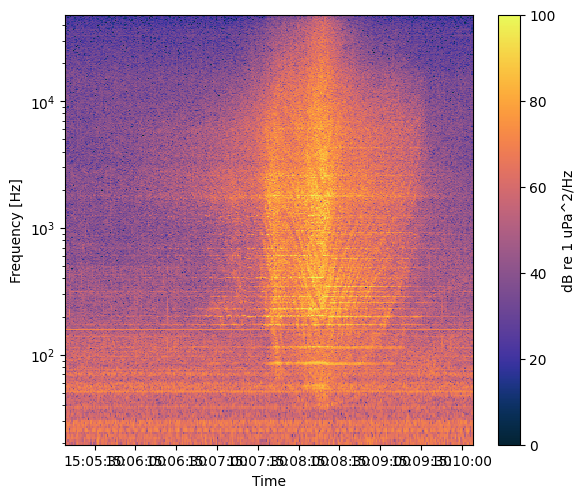

In [9]:
fmin = 20
fmax = 48000

# Create high res spectogram
fig, ax = acoustics.graphics.plot_spectogram(
    spsdl, fmin, fmax, kwargs={"cmap": thermal, "vmin": 0, "vmax": 100}
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))


### Window Averaging

From the mean square spectral density level we can apply a couple functions. Other functions exist that can be used to time-average or frequency band-average the spectral density level. In the following code block, we split the 5 minutes of measurements into 10 second intervals and find the median, 25% and 75% quantiles of each interval using the `time_average` function.

In [10]:
# Time average into 30 s windows
window = 30
spsdl_50 = acoustics.time_average(spsdl, window, method="median")
spsdl_25 = acoustics.time_average(spsdl, window, method="quantile", method_arg=0.25)
spsdl_75 = acoustics.time_average(spsdl, window, method="quantile", method_arg=0.75)

We can then using the `plot_spectra` function in the graphics submodule to plot the average median and quantiles of each 10 s window.

Text(0.5, 1.0, 'Median and Quantile Sound Pressure Spectral Density Level')

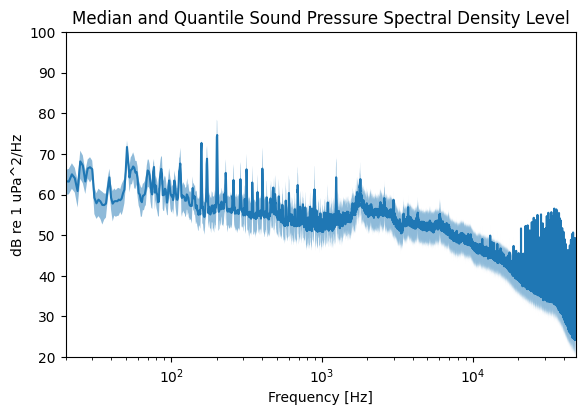

In [11]:
# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spsdl_50.mean("time_bins"), fmin, fmax)
ax.fill_between(
    spsdl_50["freq"],
    spsdl_25.mean("time_bins"),
    spsdl_75.mean("time_bins"),
    alpha=0.5,
    facecolor="C0",
    edgecolor=None
)
ax.set_ylim(20, 100)
ax.set_title("Median and Quantile Sound Pressure Spectral Density Level")

### Sound Pressure Level

From the calibrated mean squre spectral densities, we can also calculate sound pressure levels (SPLs). We can use the function `sound_pressure_level` to calculate the median SPL over a specific frequency range. This will calculate an SPL for each timestamp that we can then average together to get a single measurement for this minute-long file.

In [13]:
# Sound pressure level
spl = acoustics.sound_pressure_level(spsd, fmin, fmax)
spl_q50 = acoustics.time_average(spl, window, method="median")
print(f"spl_median: {spl_q50.mean().values}")

spl_median: 98.7198582492474


### Third Octave Sound Pressure Level

In addition to the overal SPL, we can calculate the SPL in each third octave band using the function `third_octave_sound_pressure_level`. An octave is a frequency band where the upper frequency is double (2^1) that of the lower frequency. The third octave is a frequency band were the upper frequency is 2^(1/3) times the lower frequency. 

[Text(0, 0.5, 'Third Octave SPL [dB re 1 uPa]')]

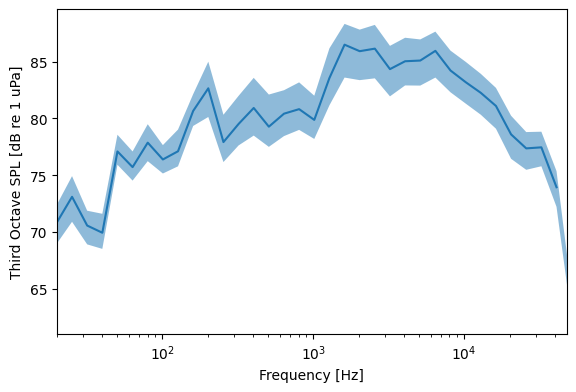

In [14]:
# Median third octave sound pressure level
spl3 = acoustics.third_octave_sound_pressure_level(spsd, fmin, fmax)

# Time average into 30 s windows
window = 30
spl3_q50 = acoustics.time_average(spl3, window, method="median")
spl3_q25 = acoustics.time_average(spl3, window, method="quantile", method_arg=0.25)
spl3_q75 = acoustics.time_average(spl3, window, method="quantile", method_arg=0.75)

# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spl3_q50.mean("time_bins"), fmin, fmax)
ax.fill_between(
    spl3_q50["freq_bins"],
    spl3_q25.mean("time_bins"),
    spl3_q75.mean("time_bins"),
    alpha=0.5,
    facecolor="C0",
    edgecolor=None
)
ax.set(ylabel="Third Octave SPL [dB re 1 uPa]")

### Decidecade Sound Pressure Levels

The IEC-40 requests the decidecade frequency band SPLs, which have a bandwidth of 2^(1/10). We can calculate the SPL in each decidecade (tenth octave) band using the function `decidecade_sound_pressure_level`.

[Text(0.5, 0, 'Frequency [Hz]'), Text(0, 0.5, 'Decidecade SPL [dB re 1 uPa]')]

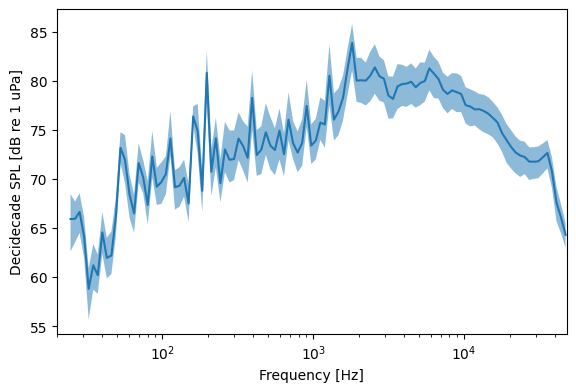

In [15]:
# Decidecade octave sound pressure level (also interquartile)
spl10 = acoustics.decidecade_sound_pressure_level(spsd, fmin, fmax)

# Time average into 30 s windows
window = 30
spl10_q50 = acoustics.time_average(spl10, window, method="median")
spl10_q25 = acoustics.time_average(spl10, window, method="quantile", method_arg=0.25)
spl10_q75 = acoustics.time_average(spl10, window, method="quantile", method_arg=0.75)

# Plot medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spl10_q50.mean("time_bins"), fmin, fmax)
ax.fill_between(
    spl10_q50["freq_bins"],
    spl10_q25.mean("time_bins"),
    spl10_q75.mean("time_bins"),
    alpha=0.5,
    facecolor="C0",
    edgecolor=None
)
ax.set(xlabel="Frequency [Hz]", ylabel="Decidecade SPL [dB re 1 uPa]")